# **Microsoft Stock-Forecasting using LSTM**


# **Dataset**

>  Get dataset from https://finance.yahoo.com/quote/MSFT/history/

choose max in time period, then download

In [1]:
import pandas as pd
df=pd.read_csv('MSFT.csv')

df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060524,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062686,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063767,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062145,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061065,47894400
...,...,...,...,...,...,...,...
9285,2023-01-13,237.000000,239.369995,234.919998,239.229996,238.111755,21333300
9286,2023-01-17,237.970001,240.910004,237.089996,240.350006,239.226532,29831300
9287,2023-01-18,241.570007,242.380005,235.520004,235.809998,234.707748,30028700
9288,2023-01-19,233.779999,235.520004,230.679993,231.929993,230.845886,28623000


In [2]:
df = df[['Date','Close']]

df

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9285,2023-01-13,239.229996
9286,2023-01-17,240.350006
9287,2023-01-18,235.809998
9288,2023-01-19,231.929993


In [3]:
df['Date']

0       1986-03-13
1       1986-03-14
2       1986-03-17
3       1986-03-18
4       1986-03-19
           ...    
9285    2023-01-13
9286    2023-01-17
9287    2023-01-18
9288    2023-01-19
9289    2023-01-20
Name: Date, Length: 9290, dtype: object

## change the type from string to datetime

In [4]:
import datetime

def str_to_datetime(str):
  split = str.split('-')
  y, m, d = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=y, month=m, day=d)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [5]:
df['Date'] = df['Date'].apply(str_to_datetime)

df['Date']

<ipython-input-5-a035e129bcba>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


0      1986-03-13
1      1986-03-14
2      1986-03-17
3      1986-03-18
4      1986-03-19
          ...    
9285   2023-01-13
9286   2023-01-17
9287   2023-01-18
9288   2023-01-19
9289   2023-01-20
Name: Date, Length: 9290, dtype: datetime64[ns]

# we want the 'Date' to be the index

In [6]:
df.index = df.pop('Date')

df

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090
...,...
2023-01-13,239.229996
2023-01-17,240.350006
2023-01-18,235.809998


# Plot the data

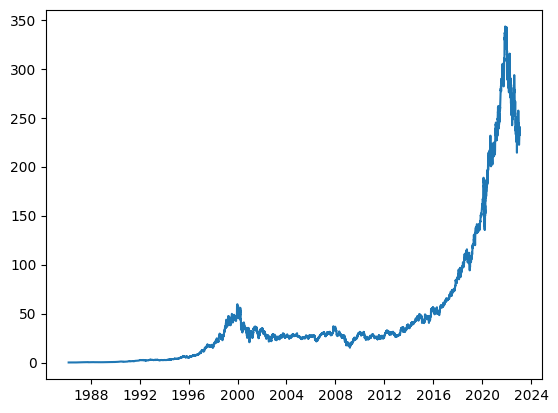

In [7]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

In [8]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2018-03-25', # start
                                '2023-01-20', # end(today)
                                n=3) 
# time was taken from 2018 till today and before 2018 was ignored, as the graph above shows the huge difference in gradient between before and after 2018
# as the data before 2018 would damage the results

windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2018-03-25,93.129997,92.480003,89.790001,87.180000
1,2018-03-27,89.790001,87.180000,93.779999,89.470001
2,2018-03-28,87.180000,93.779999,89.470001,89.389999
3,2018-03-29,93.779999,89.470001,89.389999,91.269997
4,2018-04-02,89.470001,89.389999,91.269997,88.519997
...,...,...,...,...,...
1210,2023-01-13,228.850006,235.770004,238.509995,239.229996
1211,2023-01-17,235.770004,238.509995,239.229996,240.350006
1212,2023-01-18,238.509995,239.229996,240.350006,235.809998
1213,2023-01-19,239.229996,240.350006,235.809998,231.929993


target-3....target-1 are inputs, target is the output

note -3 means the value 3 days before the date

In [9]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((1215,), (1215, 3, 1), (1215,))

date: coloumn
X: 3d matrix
y: output



# **Split the data into train, test and validation**

> train = 0.8

> validation = 0.1

> test = 0.1



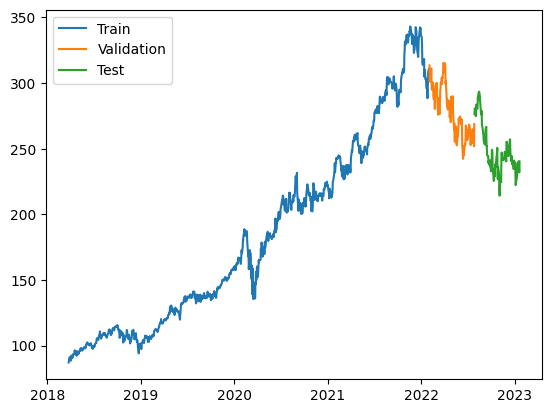

In [10]:
q_80 = int(len(dates)*0.8)
q_90 = int(len(dates)*0.9)

dates_train, X_train, y_train = dates[ :q_80], X[ :q_80], y[ :q_80] # first 80%
dates_val, X_val, y_val = dates[q_80 : q_90], X[q_80 : q_90], y[q_80 : q_90] # 10% - 80% to 90%
dates_test, X_test, y_test = dates[q_90: ], X[q_90: ], y[q_90: ] # 10% - 90% to 10%

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

# **Make Model and tarin it**

In [11]:
from tensorflow.keras.models import Sequential # Sequential model
from tensorflow.keras.optimizers import Adam # optimizer type
from tensorflow.keras import layers

model = Sequential([
    layers.Input((3, 1)), # 3 inputs, one output
    layers.LSTM(64), # big but not really big num of neurons, the bigger the num the more complicated the model is and more prone to overfit, the more heavy duty
    layers.Dense(32, activation='relu'), # put activiation for the dense, not the LSTM
    layers.Dense(32, activation='relu'),
    layers.Dense(1) # linear
])

model.compile(loss = 'mse', 
              optimizer = Adam(learning_rate=0.001), # mean sqr error
              metrics = ['mean_absolute_error']
              )

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=150)

Epoch 1/150
31/31 [==============================] - 11s 74ms/step - loss: 37997.5938 - mean_absolute_error: 181.2719 - val_loss: 75580.1797 - val_mean_absolute_error: 274.2519
Epoch 2/150
31/31 [==============================] - 0s 8ms/step - loss: 35012.1094 - mean_absolute_error: 172.6721 - val_loss: 66692.8750 - val_mean_absolute_error: 257.5368
Epoch 3/150
31/31 [==============================] - 0s 6ms/step - loss: 25707.6699 - mean_absolute_error: 142.3076 - val_loss: 44349.1484 - val_mean_absolute_error: 209.7174
Epoch 4/150
31/31 [==============================] - 0s 7ms/step - loss: 10765.9717 - mean_absolute_error: 79.0988 - val_loss: 14012.3799 - val_mean_absolute_error: 116.8181
Epoch 5/150
31/31 [==============================] - 0s 8ms/step - loss: 5042.4326 - mean_absolute_error: 60.8902 - val_loss: 8110.9629 - val_mean_absolute_error: 88.0280
Epoch 6/150
31/31 [==============================] - 0s 7ms/step - loss: 3867.9229 - mean_absolute_error: 51.4208 - val_loss: 62

31/31 [==============================] - 1s 2ms/step
Mean Absolute Percentage Error (MAPE): 1.36%


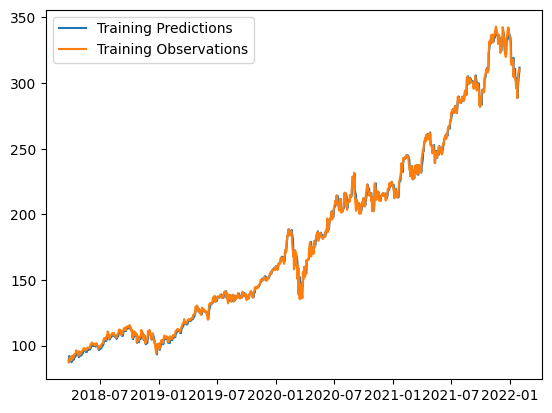

In [12]:
train_predictions = model.predict(X_train).flatten()

absolute_percentage_error = np.abs((train_predictions - y_train) / y_train) * 100
mape = np.mean(absolute_percentage_error)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

4/4 [==============================] - 0s 6ms/step
Mean Absolute Percentage Error (MAPE): 1.88%


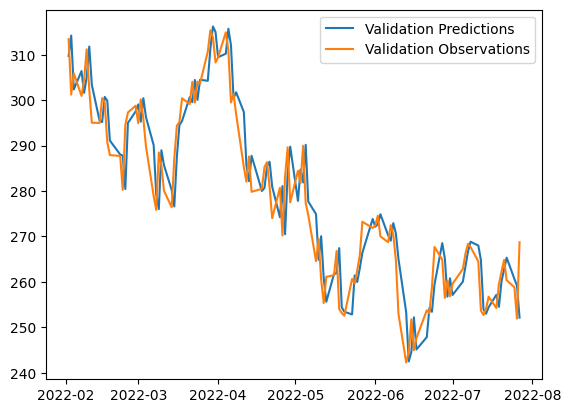

In [13]:
val_predictions = model.predict(X_val).flatten()

absolute_percentage_error = np.abs((val_predictions - y_val) / y_val) * 100
mape = np.mean(absolute_percentage_error)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

4/4 [==============================] - 0s 3ms/step
Mean Absolute Percentage Error (MAPE): 1.64%


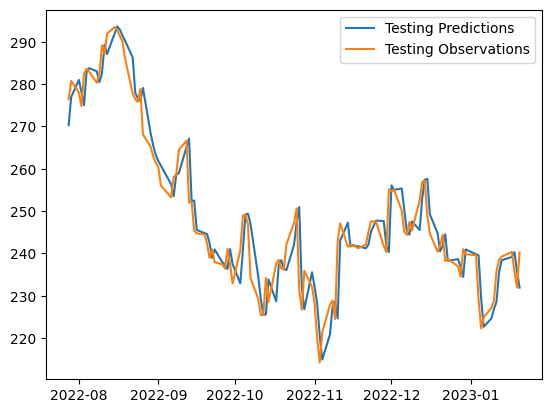

In [14]:
test_predictions = model.predict(X_test).flatten()

absolute_percentage_error = np.abs((test_predictions - y_test) / y_test) * 100
mape = np.mean(absolute_percentage_error)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

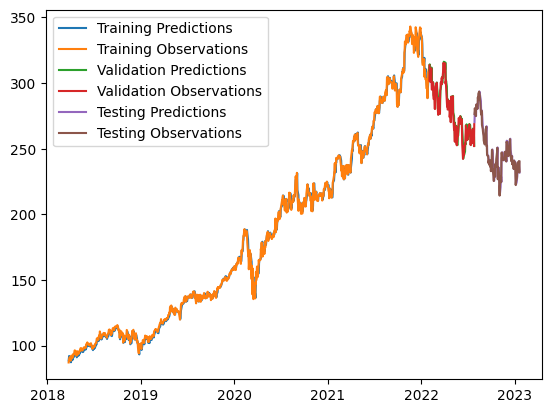

In [15]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend([
    'Training Predictions', 
    'Training Observations',
    'Validation Predictions', 
    'Validation Observations',
    'Testing Predictions', 
    'Testing Observations'
    ])

In [16]:
# calculate accuracy of the model
train_accuracy = 100 - np.mean(np.abs(train_predictions - y_train) / y_train) * 100
val_accuracy = 100 - np.mean(np.abs(val_predictions - y_val) / y_val) * 100
test_accuracy = 100 - np.mean(np.abs(test_predictions - y_test) / y_test) * 100

# show accuracy
print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Validation Accuracy: {val_accuracy:.2f}%")
print(f"Testing Accuracy: {test_accuracy:.2f}%")


Training Accuracy: 98.64%
Validation Accuracy: 98.12%
Testing Accuracy: 98.36%


# **Make Long-term prediction**

In [ ]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

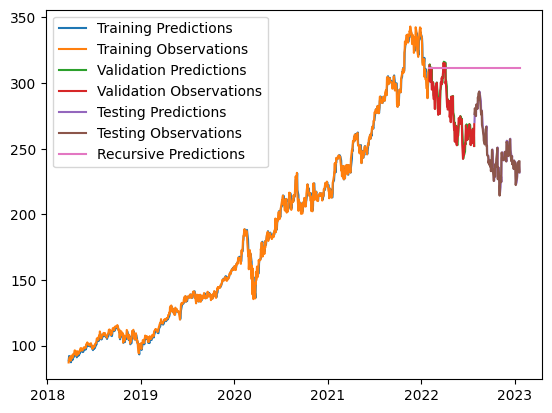

In [18]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions) # added
plt.legend([
    'Training Predictions', 
    'Training Observations',
    'Validation Predictions', 
    'Validation Observations',
    'Testing Predictions', 
    'Testing Observations',
    'Recursive Predictions' # added
    ])

In [19]:
# calculate accuracy for recursive predictions
recursive_accuracy = 100 - np.mean(np.abs(recursive_predictions - y[q_90:]) / y[q_90:]) * 100

# show accuracy
print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Validation Accuracy: {val_accuracy:.2f}%")
print(f"Testing Accuracy: {test_accuracy:.2f}%")
print(f"Recursive Prediction Accuracy: {recursive_accuracy:.2f}%")


Training Accuracy: 98.64%
Validation Accuracy: 98.12%
Testing Accuracy: 98.36%
Recursive Prediction Accuracy: 74.05%


## The graph and the statistics shows that the model has no idea on how to predict values in the long term.